## Part 1 Software Implementation with OpenCV-Python Library

### 1. Introduction

In the FIR PBL, we were doing a simple application in 1D digital signal processing. We briefly understood the basic concepts of pipeline, unroll and storage optimization in HLS. In this case, we will focus on how to perform the hardware acceleration problem in image processing through architectural optimization. After receiving an image, how should we process it? We need to extract the image features and simplify the information carried by the image as the subsequent other image processing. Sobel operator which extracts the image edge information is a common operator and will be our main content in this time.

The Sobel operator is a common operator used to extract image edge information and can be used to find the points in a digital image with significant changes in brightness, as shown in the figure below. After the Sobel operator, the edges of the image are clearly outlined. We can use the extracted edge information to detect defects, etc. to design computer vision applications.

<img src="./image/Sobel_effect.png" alt="Sobel_effect.png" style="zoom:50%;" />

The essence of the Sobel operator is to obtain the first-order gradient of a digital image by a convolution operation. It does this by weighting the difference between the grayscale values of each pixel in the image's pro-domain to make its value larger at the edge position. In terms of implementation, the Sobel operator is convolved with the original image by two 3x3 kernels to obtain the approximate gradient - one kernel for horizontal gradient detection and the other for vertical.

If we denote the original image as $A$ and the approximate gradient extraction results in the horizontal and vertical directions as $G_x$ and $G_y$ , and $*$ denotes the two-dimensional convolution process, this computational process can be expressed as follows.

#### X-direction kernel (Gx):

$$
G_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

#### Y-direction kernel (Gy):

$$
G_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

The process of 2D convolution is not complicated, i.e., multiplying and accumulating the convolution kernel and the pixels at the corresponding positions on the image. In the figure below, the gradient extraction in the horizontal direction is taken as an example. Let's consider the first element of the first convolution result. 3x3 convolution kernel will be moved to the top left corner of the original image first, and then all the 9 pixels on the kernel will correspond to the 9 pixels on the original image. After that, the pixels in the corresponding positions will be multiplied and added up (as in the process in the upper-right black box), and the result will be one pixel of the convolution result (4).

<img src="./image/2Dconv1.png" alt="2Dconv1.png" style="zoom:50%;" />

In the next step, we move the convolution kernel one frame to the right on the original image, at which point the convolution kernel will again correspond to the new 9 pixels on the image. We still perform the multiplication and accumulation of the pixels at the corresponding positions (as the process in the black box in the upper right corner), and the result will be the second pixel of the convolution result.

<img src="./image/2Dconv2.png" alt="2Dconv2.png" style="zoom:50%;" />

In this way, the convolution kernel will traverse the whole image in turn to obtain the gradient extraction results in the horizontal direction.

After we obtain the two convolution results $G_x$ and $G_y$, we do not get the complete gradient information because they both reflect only the individual gradients in the horizontal and vertical directions, and we also need to combine the two gradients to calculate the magnitude of the total gradient, as is standard practice:

$$
G = \sqrt{G_x^2 + G_y^2}
$$

In the calculation, this process will require squaring and opening the root sign. To simplify the calculation, we sometimes also approximate it by changing it to a direct summation, which can be written as follows. The gradient direction  $\theta$  is given by:

$$
\theta = \arctan{\left(\frac{G_y}{G_x}\right)}
$$

Let's look at an example of Lena, a very famous image in computer vision. The figure below shows the result of the gradients extracted from the Lena image in the horizontal and vertical directions and the total gradients. In the calculation of the Sobel operator, we need to convolve the image twice first to extract the gradients in both directions, and then add them together into one gradient result.

<img src="./image/Lena_with_sobel.png" alt="Lena_with_sobel.png" style="zoom:70%;" />



### 2. Using Sobel in OpenCV-Python

Let's consider the implementation of the Sobel operator in `Python`. `OpenCV` is an open source computer vision library first initiated and maintained by the Intel team, and it is based on the C/C++ language. You can find implementations of many operators in `OpenCV`. The OpenCV-Python library we will be using is a Python wrapper version of the original C++ implementation.

We first import the `OpenCV-Python` library for image processing and the `matplotlib` library for drawing. The `imread` method can read the image in jpg format. The original image is a three-channel image of 400x400 size, which can be displayed by the `imshow` method.

#### 2.1 Read the Image in JPG Format

original image size：(512, 512, 3)


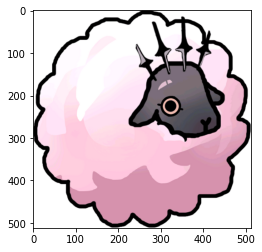

In [2]:
import cv2  
import numpy as np  
from matplotlib import pyplot as plt  
img = cv2.imread("./image/sheep.png")  
print("original image size：{}".format(img.shape))  
plt.imshow(img[:,:,::-1])

#### 2.2 Converting RGB to Grayscale

In the following, we convert the RGB image into a grayscale map to visualize the change of data dimension.


gray image size：(512, 512)


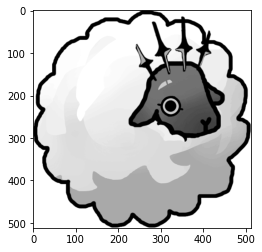

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
print("gray image size：{}".format(gray.shape))  
plt.imshow(gray,cmap='gray')  

#### 2.3 Extracting Edges Using Sobel Operator

The implementation of Sobel in `OpenCV` is `cv2.Sobel()`, which we can use in the same way as the code below. The first and second arguments are the incoming image and data format respectively, here the grayscale map obtained in the previous step is used, in 8-bit unsigned integer format. The last two parameters represent the order of the derivatives x and y, which we set to 1. `sobel_x` and `sobel_y` are the results of edge detection in the horizontal and vertical directions, and `sobel_res` is the gradient obtained by summing the two and truncating them between 0 and 255, which is the final result we get. Finally, we plot the above three images together for comparison.

Time cost with Python：0.007042884826660156s


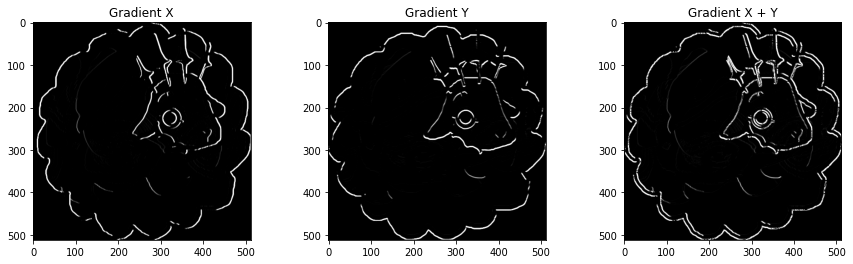

In [4]:
import time  
start_time = time.time()  
sobel_x =cv2.Sobel(gray,cv2.CV_8U ,1,0)  
sobel_y = cv2.Sobel(gray,cv2.CV_8U ,0,1)  
sobel_res = np.clip(sobel_x + sobel_y, 0, 255)  
end_time = time.time()  
print("Time cost with Python：{}s".format(end_time - start_time))  
fig_sobel3 = plt.figure()  
fig_sobel3.set_figheight(4)  
fig_sobel3.set_figwidth(15)  

# gradient x  
fig_1 = fig_sobel3.add_subplot(131)  
fig_1.title.set_text('Gradient X')  
plt.imshow(sobel_x,cmap='gray')  

# gradient y  
fig_2 = fig_sobel3.add_subplot(132)  
fig_2.title.set_text('Gradient Y')  
plt.imshow(sobel_y,cmap='gray')  

# gradient  
fig_3 = fig_sobel3.add_subplot(133)  
fig_3.title.set_text('Gradient X + Y')  
plt.imshow(sobel_res,cmap='gray') 


--------

<p align="center">Copyright&copy; 2024 Advanced Micro Devices</p>